In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

### Загрузка датасета

In [5]:
data = pd.read_csv('C:\\Users\\derev\\Downloads\\movies_subtitles.csv')

### Обработка датасета

In [6]:
# Предобработка данных: удаление пропущенных значений
data['text'] = data['text'].fillna('')

# Уменьшение размера данных: использование только первых 10000 строк
data = data.head(10000)

# Объединение всех текстов в один
text = ' '.join(data['text'].values.tolist())


### Токенизация по символам

In [7]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts([text])
total_chars = len(tokenizer.word_index) + 1

### Создание обучающих последовательностей

In [8]:
input_sequences = []
for line in data['text'].values.tolist():
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [9]:
# Определение максимальной длины последовательности
max_sequence_len = max([len(x) for x in input_sequences])

# Паддинг последовательностей
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Создание входных и выходных данных
X, y = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=total_chars)

### Определение модели

In [ ]:
model = Sequential()
model.add(Embedding(total_chars, 100))
model.add(SimpleRNN(150, return_sequences=False))
model.add(Dense(total_chars, activation='softmax'))

### Компиляция модели

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Обучение

In [23]:
# Тренировка модели
history = model.fit(X, y, epochs=30, verbose=1)

Epoch 1/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 165s 15ms/step - accuracy: 0.3503 - loss: 2.2655
Epoch 2/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 174s 16ms/step - accuracy: 0.4718 - loss: 1.7570
Epoch 3/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 171s 16ms/step - accuracy: 0.4952 - loss: 1.6633
Epoch 4/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 184s 17ms/step - accuracy: 0.5081 - loss: 1.6187
Epoch 5/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 193s 18ms/step - accuracy: 0.5157 - loss: 1.5899
Epoch 6/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 190s 18ms/step - accuracy: 0.5185 - loss: 1.5761
Epoch 7/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 186s 17ms/step - accuracy: 0.5230 - loss: 1.5626
Epoch 8/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 198s 18ms/step - accuracy: 0.5243 - loss: 1.5540
Epoch 9/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 187s 17ms/step - accuracy: 0.5242 - loss: 1.5520
Epoch 10/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - accuracy: 0.5261 - loss: 1.5457
Epoch 11/30
10736/10736 ━━━━━━━━━━━━━━━━━━━━ 180s 17ms/step - accurac

### Метрики

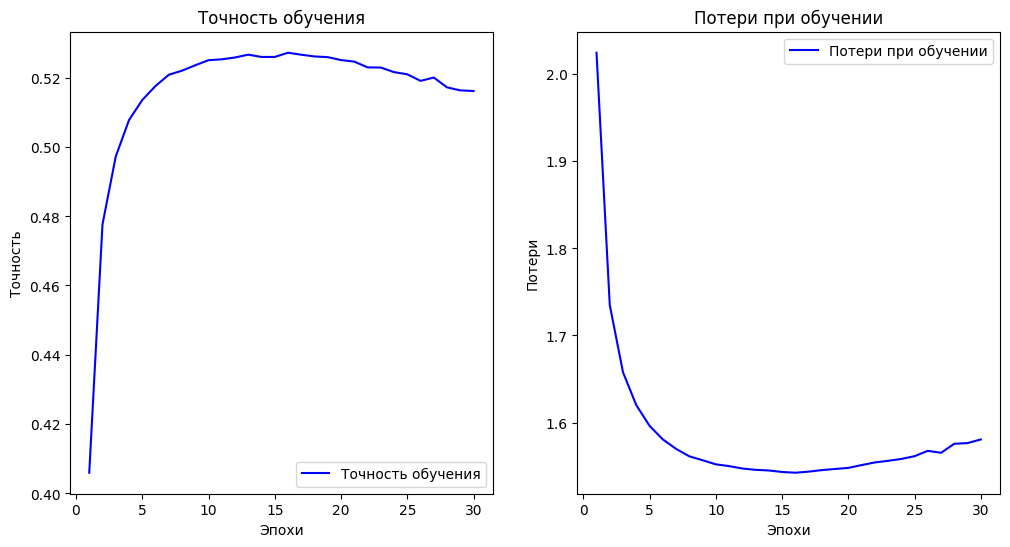

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Точность обучения')
    plt.title('Точность обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Потери при обучении')
    plt.title('Потери при обучении')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()

    plt.show()

plot_history(history)

In [25]:
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Loss: 1.5677452087402344, Accuracy: 0.5175226330757141


### Генерация текста

In [26]:
# Генерация текста
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_char_index = np.argmax(predicted, axis=1)[0]
        predicted_char = tokenizer.index_word[predicted_char_index]
        seed_text += predicted_char
    return seed_text

In [31]:
# Пример генерации текста
seed_text = "Hi"
next_words = 100
print(generate_text(seed_text, next_words, max_sequence_len))

His world be a little good one of the staring the staring the staring the staring the staring the star


Как можно увидеть, у модели вышла достаточно низкая точность и высокие потери, но, к сожалению, вычислительной мощности моего ноутбука не хватает на то, чтобы обучить ее лучше. При добавлении слоев в модель результат выходил еще хуже, точность падала, пока потери росли. С не очень удачным обучением связан и результат генерации, зацикливающийся на одних и тех же словах.